In [1]:
using Plots

## Baseline Parameterization

In [2]:
k = 6  # price_intervals
α = 0.3  # step_size
δ = 0.95  # discount_factor

P = 0:1/k:1  # prices/action space (state space is competitor prices)

params = (k, α, δ)

(6, 0.3, 0.95)

## Learning

### Define functions

In [13]:
mutable struct Firm
    Q::AbstractMatrix  # inidices = price * k + 1 (to be 1-based, ints)
    prices::Array  # price history (save all for later calculations/plotting)
end
p2in(p) = Int(p * k + 1) # convert price p to index in Q matrix

p2in (generic function with 1 method)

In [4]:
# linear demand (collusive price = 0.5, per-firm profit = 0.125)
function D_i(p_i, p_j)
    if p_i < p_j
        1 - p_i
    elseif p_i == p_j
        0.5 * (1 - p_i)
    else
        0
    end
end


# profit
π_i(p_i, p_j) = p_i * D_i(p_i, p_j)

π_i (generic function with 1 method)

In [5]:
# argmax but returns random if multiple found
rand_argmax(arr::Array) = rand(findall(x -> x == maximum(arr), arr))

rand_argmax (generic function with 1 method)

In [6]:
# update firm's Q matrix at time t
function update!(Q_i::Matrix, p_i::Array, p_j::Array, t::Int)
    
    prev_est = Q_i[p2in(p_i[t]), p2in(p_j[t])]
    new_est =  π_i(p_i[t], p_j[t]) + δ*π_i(p_i[t], p_j[t+1]) + δ^2*maximum(Q_i[:, p2in(p_j[t+1])])
    Q_i[p2in(p_i[t]), p2in(p_j[t])] = (1 - α) * prev_est + α * new_est

    return Q_i
end

update! (generic function with 1 method)

In [14]:
function duopoly(T::Int)
    
    # initialize firms w/ t = {1, 3}
    Q1 = zeros(length(P), length(P))
    Q2 = zeros(length(P), length(P))
            
    prices1 = Array{Float64}(undef,T)
    prices2 = Array{Float64}(undef,T)
            
    prices1[1] = prices1[2] = rand(P)  # t=1
    prices2[1] = prices2[2] = rand(P)  # t=2
    prices1[3], prices2[3] = rand(P), prices2[2]  # t=3
    
    firms = (Firm(Q1, prices1), Firm(Q2, prices2))
    
    # update Q matricies
    i, j = 2, 1  # i = firm2 b/c t=4
    for t in 4:T
        
        # update Q at t-2
        p_i, p_j = firms[i].prices, firms[j].prices
        Q_i = firms[i].Q
        update!(Q_i, p_i, p_j, t-2)
        
        # set new prices
        ϵ = (0.000001)^(t/T)  # ϵ = (1 - θ)^t where decay parameter θ is set s.t. ϵ_T = .0001%
        p_i[t] = rand() < ϵ ? rand(P) : (rand_argmax(Q_i[:, p2in(p_j[t-1])]) - 1) / k
        p_j[t] = p_j[t-1] 
        
        # swap i and j b/c sequential
        i, j = j, i  
    end
    
    return firms
end

duopoly (generic function with 1 method)

In [9]:
function getprofits(prices1, prices2)
    profits1 = [π_i(prices1[t], prices2[t]) for t in 1:length(prices1)]
    profits2 = [π_i(prices2[t], prices1[t]) for t in 1:length(prices1)] 
    profits1, profits2
end

getprofits (generic function with 1 method)

In [104]:
function makeplots(prices1, prices2, profits1, profits2, step::Int; titled = "")
    x = 1:step:length(prices1)
    p1 = plot(x, [prices1[x] prices2[x]], ylim =(0, 1), title = "Price (every $(step)th)")
    p2 = plot(x, [profits1[x] profits2[x]], title = "Profit (every $(step)th)")
    plot(p1, p2, label=["Firm 1" "Firm 2"], layout=(2,1), plot_title=titled, titlelocation=:left)
end

makeplots (generic function with 2 methods)

### Run experiment

In [73]:
T = 500_000

firms = (firm1, firm2) = duopoly(T)

# calculate profit history
profits1, profits2 = getprofits(firm1.prices, firm2.prices)

firm1.prices[end], profits1[end], firm2.prices[end], profits2[end]

(0.5, 0.125, 0.5, 0.125)

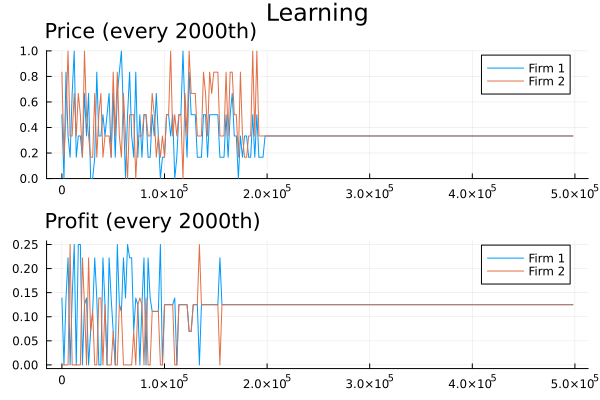

In [105]:
makeplots(firm1.prices, firm2.prices, profits1, profits2, 2_000, titled = "Learning")

## Performance metrics

### Define metrics

In [47]:
# profitability: avg profit of final 1000 periods
Π_i(profits::Array{Float64}) = sum(profits[end-999:end]) / 1000

Π_i(profits1), Π_i(profits2)

(0.125, 0.125)

#### PROBLEM - convergence method doesn't work properly (optimal Q-matrix varies)

In [48]:
# optimality: ratio of estimated and best-response discounted future profits
function Γ_i(firm_i::Firm, firm_j::Firm; max_periods=10_000_000)
    
    ind_i, ind_j = (p2in(firm_i.prices[end]), p2in(firm_j.prices[end]))
    
    # calculate optimal Q-function given current competitor strategy
    main = Firm(copy(firm_i.Q), firm_i.prices[end-1:end])
    comp = Firm(copy(firm_j.Q), firm_j.prices[end-1:end])
    
    firms = (main, comp)
    
    # loop over all action-state pairs in Q until convergence
    # convergence if Q doesn't change for 100,000 consecutive periods (Calvano 2020, missing from Klein 2021)
    i, j = 1, 2
    periods = 0
    prev_Q = copy(firms[i].Q)
    unchanged = 0  # periods Q has remained unchanged
    while true
        
        # stop if hasnt converged
        periods == max_periods && break
        
        # update Q if firm is main (to get optimal)
        if i == 1
            
            ind_i, ind_j = p2in(firms[i].prices[1]), p2in(firms[j].prices[1])
            old = firms[i].Q[ind_i, ind_j]
            update!(firms[i].Q, firms[i].prices, firms[j].prices, 1)
            
            # update unchanged and check for convergence
            firms[i].Q == prev_Q ? (unchanged += 1) : (unchanged = 0)
            unchanged == 100_000 && break
            prev_Q = copy(firms[i].Q)
            
            # set epsilon to .1 b/c cant use decay since dont know when will converge 
            # perhaps theres a better value / way to decay?
            ϵ = .1
            firms[i].prices[2] = rand() < ϵ ? rand(P) : 
                (rand_argmax(firms[i].Q[:, p2in(firms[j].prices[2])]) - 1) / k
        else
            firms[i].prices[2] = (argmax(firms[i].Q[:, p2in(firms[j].prices[2])]) - 1) / k
            
        end
        firms[j].prices[1] = firms[j].prices[2]  # future price becomes current price 
        
        i, j = j, i  
        periods += 1
    end
    firm_i.Q[ind_i, ind_j] / maximum(firms[1].Q[:, ind_j])
end

Γ_i (generic function with 1 method)

In [49]:
Γ_i(firm2, firm1) 

1.0

In [51]:
# check if outcome is a Nash equilibrium
isNash(firm_i, firm_j; tol = 0.000001) = isapprox(Γ_i(firm_i, firm_j), 1, atol = tol) && 
    isapprox(Γ_i(firm_j, firm_i), 1, atol = tol)

isNash(firm1, firm2)

true

### Let firms compete (for testing)

In [39]:
function compete(firm_i::Firm, firm_j::Firm, periods::Int)
    firms = (firm_i, firm_j)
    tprices = (Array{Float64}(undef,periods), Array{Float64}(undef,periods))
    tprices[1][1] = rand(P)
    
    i, j = 2, 1
    for t in 2:periods
        tprices[i][t] = (argmax(firms[i].Q[:, p2in(tprices[j][t-1])]) - 1) / k
        tprices[j][t] = tprices[j][t-1] 
        i, j = j, i
    end
    tprices
end

compete (generic function with 1 method)

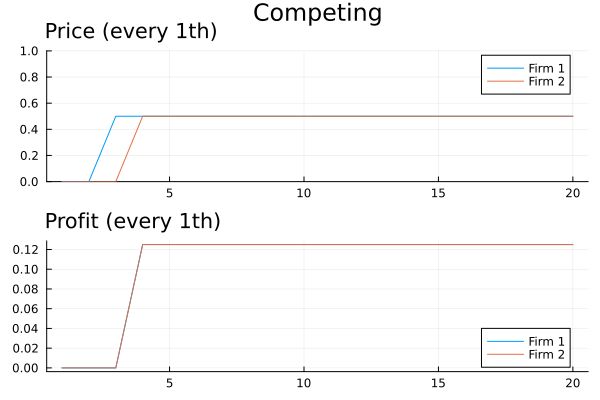

In [94]:
tprices = compete(firm1, firm2, 20)
tprofits1, tprofits2 = getprofits(tprices[1], tprices[2])
makeplots(tprices[1], tprices[2], tprofits1, tprofits2, 1, titled="Competing")

### Frequency of convergence prices on multiple runs

#### Figure 2 in Klein 2021 had 667/1000 runs lead to a Nash equilibrium

In [ ]:
T = 500_000
runs = 100 # 1000

convg_prices = Array{Tuple{Float64, Float64}}(undef,runs)
nashcount = 0
for i in 1:runs
    firm1, firm2 = duopoly(T)
    convg_prices[i] = (firm1.prices[end], firm2.prices[end])
    
    nashcount += isNash(firm1, firm2)
end

In [ ]:
nashcount  # inaccurate b/c problem w/ optimality function

In [ ]:
freq = Dict()
for tup in convg_prices
    freq[tup] = get(freq, tup, 0) + 1
end
sorted = sort(freq, byvalue=true, rev=true)